## Bayesian Optimization with multiple objectives
Our pipeline should be as follows:
1. Define our design space as a grid or hyperplane etc
2. Define a model as surrogate to compute a score between target and a response query
3. Define acquistion function to score candidates
4. Define a selector to select candidate points
4. Define the optimization routine for the problem

In [1]:
import os
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
import pdb
from botorch.utils import standardize

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [2]:
def branin(x):
    x1 = 15*x[0]-5
    x2 = 15*x[1]
    
    t1 = x2 - (x1**2)*(5.1/(4*np.pi**2)) + (5/np.pi)*x1 -6
    t2 = 10*(1-(1/(8*np.pi)))*np.cos(x1) + 10
    
    return t1**2 + t2

def currin(x):
    x1 = x[0]
    x2 = x[1]
    
    factor = (1-np.exp(-1/(2*x2)))
    numer = (2300*x1**3) + (1900*x1**2) + (2092*x1) + 60
    denom = 100*x1**3 + 500*x1**2 + 4*x1 +20
    
    return factor*(numer/denom)

def true_function(x):
    return -torch.stack([branin(x), currin(x)])

def batch_true_function(x):
    out = []
    for xi in x.squeeze(1):
        out.append(true_function(xi))
        
    return torch.stack(out, dim=0)

In [3]:
from botorch.test_functions.multi_objective import BraninCurrin

problem = lambda x : batch_true_function(x).to(**tkwargs)
ref_point = torch.tensor([-18,-6]).to(**tkwargs)

In [4]:
# 1. design space
from head import Grid
import numpy as np

X = np.linspace(0,1, num=100) 
Y = np.linspace(0,1, num=100)
grid = Grid(X,Y)
points = torch.from_numpy(grid.points)
choices = points
N_INIT = 6

def generate_initial_data(n=6):
    soboleng = torch.quasirandom.SobolEngine(dimension=1)
    train_xid = torch.floor(soboleng.draw(n)*len(grid)).to(**tkwargs)
    train_x = choices[train_xid.long(),:]
    train_obj = problem(train_x)
    
    return torch.squeeze(train_x), torch.squeeze(train_obj)

train_x, train_obj = generate_initial_data(n=N_INIT)


In [5]:
# 2. define your model
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
                        outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [6]:
# 3. Define acqusition function
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.objective import LinearMCObjective

obj = LinearMCObjective(weights=torch.tensor([0.5, 0.5]).to(**tkwargs))
acq_fun = lambda model: qUpperConfidenceBound(model, beta=0.1, objective=obj)

In [7]:
# 4. define a optimization routine for acqusition function 
from botorch.optim.optimize import optimize_acqf_discrete

BATCH_SIZE = 4

def selector(acquisition):
    new_x, _ = optimize_acqf_discrete(
        acq_function = acquisition,
        q=BATCH_SIZE,
        choices = choices
    )
    new_obj = problem(new_x)
    return new_x, new_obj


In [8]:
# 5. define the opitmization loop

from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.optim.fit import fit_gpytorch_torch

torch.manual_seed(0)


N_ITERATIONS = 25

verbose = False

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ITERATIONS + 1):    
    
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition modules using a QMC sampler
    acquisition = acq_fun(model)

    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)

    # update training points
    train_x = torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll, model = initialize_model(train_x, train_obj)

    print(".", end="")


.........................

Text(0.5, 1.0, 'Iteration')

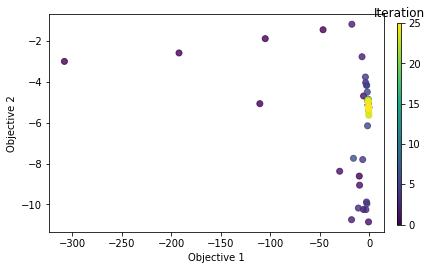

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

fig, axes = plt.subplots(1, 1)
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(N_INIT), torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

sc = axes.scatter(train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), 
    c=batch_number, alpha=0.8,
)
axes.set_xlabel("Objective 1")
axes.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

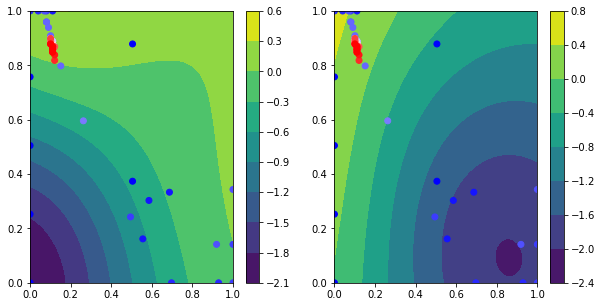

In [37]:
# plot the model
model.eval()
model.likelihood.eval()
XX, YY = grid.mesh
test_x = np.vstack(map(np.ravel, [XX, YY])).T
observed_pred = model.likelihood(model(torch.from_numpy(test_x)))
f1, f2 = observed_pred.mean.detach().numpy()

fig, axs = plt.subplots(1,2,figsize=(5*2, 5))
for ax, f in zip(axs,[f1,f2]):
    sc = ax.contourf(XX,YY,f.reshape(100,100))
    fig.colorbar(sc, ax=ax)
    ax.scatter(train_x[:,0], train_x[:,1], c=batch_number, cmap='bwr')
plt.show()